# 1. Случайный лес

1.1 Загрузка данных

In [67]:
import pandas as pd

df = pd.read_csv("breast-cancer.csv")
df.info()
df.loc[df['diagnosis'] == 'M', 'diagnosis'] = '0'
df.loc[df['diagnosis'] == 'B', 'diagnosis'] = '1'
y = df['diagnosis'].astype(int)
X = df.drop(columns=['diagnosis', 'id'], axis=1)
X.head()
print(y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

1.2 Обучение случайного леса

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score

n_estimators = 2
max_features = 0.5

model = RandomForestClassifier(n_estimators=n_estimators,
                               max_features=max_features)

model.fit(X, y)
pred = model.predict(X)
print(f"Accuracy RFC: {round(accuracy_score(y, pred), 3)}")
print(f"Precision RFC: {round(precision_score(y, pred), 3)}")
print(f"F1 Score RFC: {round(f1_score(y, pred), 3)}")

Accuracy RFC: 0.963
Precision RFC: 0.997
F1 Score RFC: 0.97


# 2. Инициализация переменных

2.1 Многозначная классификация

In [70]:
t = [1]
f = [0]
n = []
b = [0, 1]

2.2 Создание датафрейма

In [71]:
import pandas as pd

df = pd.DataFrame(index=X.index)
df['label_old'] = [n for x in X.index]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label_old  569 non-null    object
dtypes: object(1)
memory usage: 4.6+ KB


# 3. Дерево решений

3.1 Бутстрэпинг

In [72]:
X_bt = X.sample(frac=max_features)
X_bt = X_bt.sample(frac=max_features, axis='columns')
y_bt = y.loc[X_bt.index]
X_bt.shape

(284, 15)

3.2 Обучение дерева решений

In [73]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_bt, y_bt)
pred = model.predict(X_bt)
accuracy_score(y_bt, pred)

1.0

3.3 Визуализация дерева

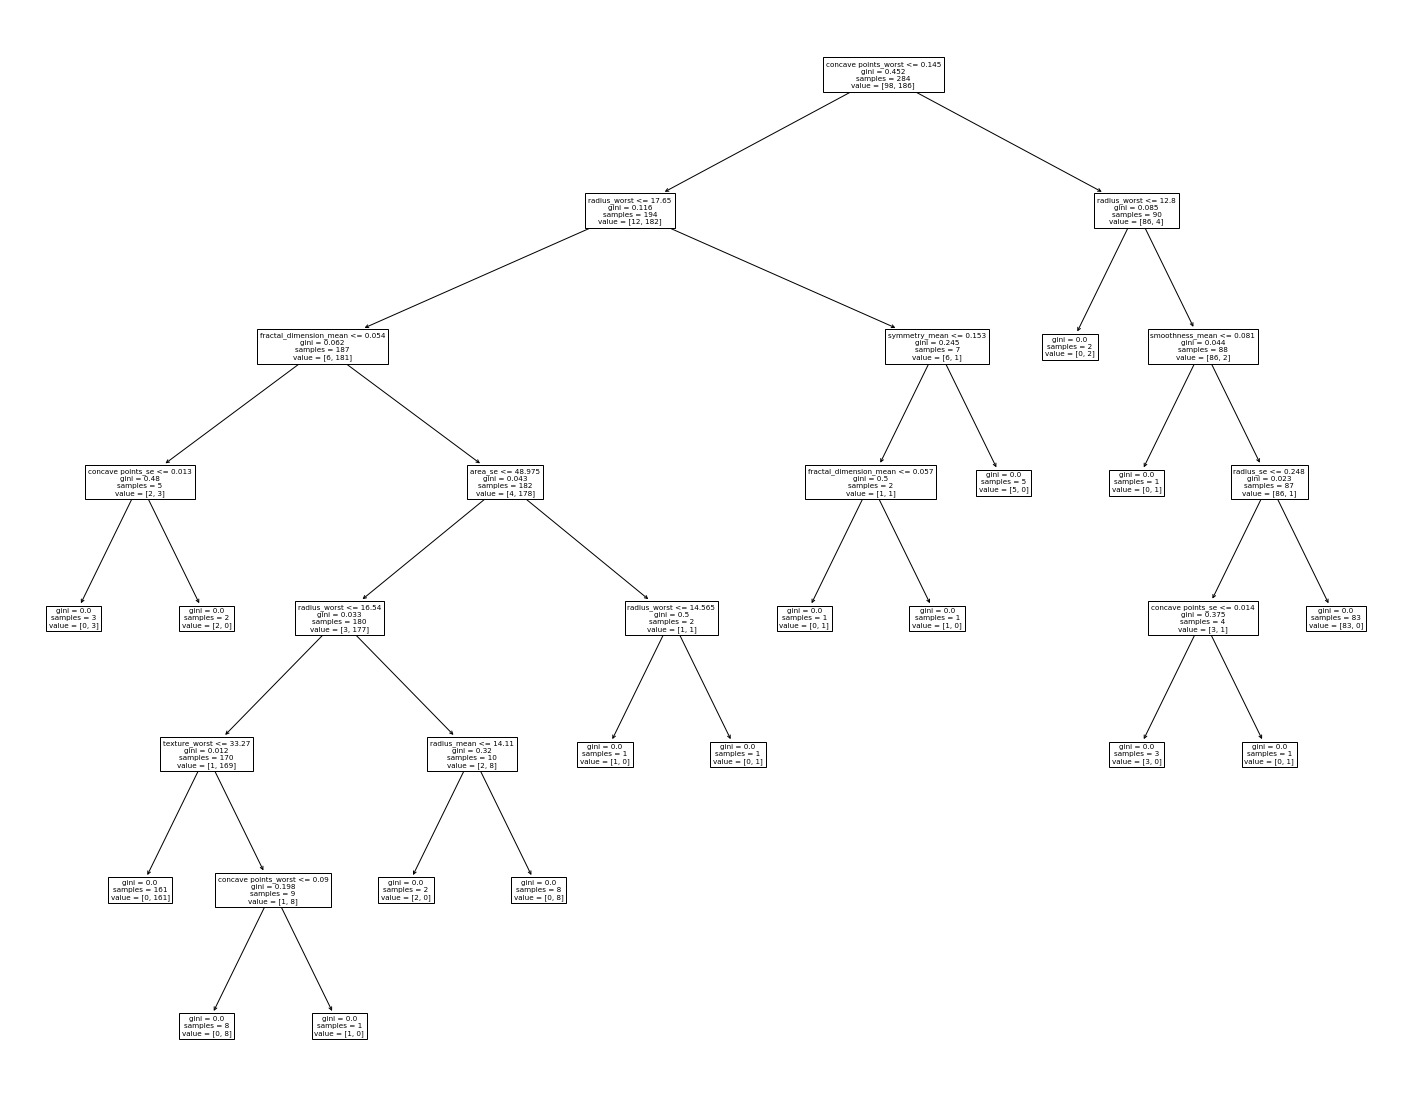

In [74]:
from sklearn import tree
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(25, 20))
tree.plot_tree(model,
               feature_names = X_bt.columns)
fig.show()

 # 4. Объединение предсказанных лейблов

4.1 Идентификация предсказанных лейблов

In [75]:
index_df = pd.DataFrame(index=X.index)
pred_df = pd.DataFrame(pred, index=X_bt.index, columns=['label_new'])
pred_df = pd.concat([index_df, pred_df], axis=1)
pred_df.head()

,label_new
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


4.2 Форматирование предсказанных лейблов

In [76]:
pred_df['label_new'] = pred_df['label_new'].apply(lambda x: n if pd.isna(x) else [int(x)])
pred_df.head()

,label_new
0,[0]
1,[0]
2,[0]
3,[0]
4,[0]


4.3 Соединение с имеющимися лейблами

In [77]:
df = pd.concat([df, pred_df], axis=1)
df.head()

,label_old,label_new
0,[],[0]
1,[],[0]
2,[],[0]
3,[],[0]
4,[],[0]


4.4 Агрегация лейблов

In [78]:
df['label_old'] = df[['label_old', 'label_new']].values.tolist()
df = df.drop(columns=['label_new'])
df.to_csv('labels.csv')
df.head()

,label_old
0,"[[], [0]]"
1,"[[], [0]]"
2,"[[], [0]]"
3,"[[], [0]]"
4,"[[], [0]]"


4.5.1 Четырехзначная конъюнкция

In [14]:
# def conj(labels):
#   a = labels[0]
#   b = labels[1]
#   if a == b:
#     return a
#   elif a == f or b == f:
#     return f
#   elif a == t:
#     return b
#   elif b == t:
#     return a
#   else:
#     return f

# df['label_old'] = df['label_old'].apply(conj)
# df.to_csv('labels.csv')
# df.head()

4.5.2 Четырехзначная дизъюнкция

In [79]:
def disj(labels):
  a = labels[0]
  b = labels[1]

  if a == b:
    return a
  elif a == t or b == t:
    return t
  elif a == f:
    return b
  elif b == f:
    return a
  else:
    return t

df['label_old'] = df['label_old'].apply(disj)
df.to_csv('labels.csv')
df.head()

,label_old
0,[]
1,[]
2,[]
3,[]
4,[]


4.6 Оценка Accuracy, Precision, F1 Score

In [80]:
from sklearn.metrics import precision_score
step = 0
pred = [x[0] if len(x) == 1 else -1 for x in df['label_old'].values]
print(f"#0 Accuracy = {round(accuracy_score(y, pred), 3)}")
pred = [x if x == 1 else 0 for x in pred]
print(f"#0 Precision = {round(precision_score(y, pred), 3)}")
pred = [x if x == 1 else 0 for x in pred]
print(f"#0 F1 Score = {round(f1_score(y, pred), 3)}")

#0 Accuracy = 0.327
#0 Precision = 1.0
#0 F1 Score = 0.685


#5. Повторение

In [88]:
step += 1

X_bt = X.sample(frac=max_features)
X_bt = X_bt.sample(frac=max_features, axis='columns')
y_bt = y.loc[X_bt.index]

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_bt, y_bt)
pred = model.predict(X_bt)

from sklearn import tree
index_df = pd.DataFrame(index=X.index)
pred_df = pd.DataFrame(pred, index=X_bt.index, columns=['label_new'])
pred_df = pd.concat([index_df, pred_df], axis=1)

pred_df['label_new'] = pred_df['label_new'].apply(lambda x: n if pd.isna(x) else [int(x)])

df = pd.concat([df, pred_df], axis=1)

df['label_old'] = df[['label_old', 'label_new']].values.tolist()
df = df.drop(columns=['label_new'])
df.to_csv('labels.csv')

df['label_old'] = df['label_old'].apply(disj)
df.to_csv('labels.csv')

pred = [x[0] if len(x) == 1 else -1 for x in df['label_old'].values]
print(f"#{step} Accuracy = {round(accuracy_score(y, pred), 3)}")

pred = [x if x == 1 else 0 for x in pred]
print(f"#{step} Precision = {round(precision_score(y, pred), 3)}")

print(f"#{step} F1 Score = {round(f1_score(y, pred), 3)}")

#8 Accuracy = 0.626
#8 Precision = 1.0
#8 F1 Score = 0.999
